In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
import torch.nn as nn

In [3]:
from torch.nn.utils import spectral_norm


def apply_spectral_norm(module, name="model"):
    for child_name, child in module.named_children():
        apply_spectral_norm(child, child_name)
        child_ref = getattr(module, child_name)
        if isinstance(child_ref, (nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d)):
            print(f"  {name}.{child_name} ({type(child_ref)})")
            setattr(module, child_name, spectral_norm(child_ref))

In [5]:
from sngp_pytorch.models import LitPretrainedRFGP
from hydra.utils import to_absolute_path
from pathlib import Path

checkpoint = "CIFAR100CustomDataModule-epoch=33-val_loss=0.00.ckpt"
model_saved = to_absolute_path(Path("models", checkpoint))
model = LitPretrainedRFGP.load_from_checkpoint(model_saved)

if torch.cuda.is_available():
    USE_GPU = True

if USE_GPU:
    model.cuda()
model.eval()
model.model.update_covariance()

In [8]:
from torchvision.datasets.svhn import SVHN
from torchvision.datasets.cifar import CIFAR10
from image_uncertainty.datasets.smooth_random import SmoothRandom
from image_uncertainty.cifar.cifar_datasets import LocalImageDataset
from os.path import join

DATA_DIR = to_absolute_path("data")


def get_external_dataset(ood_name, transform_test):

    if ood_name == "svhn":
        test_dataset = SVHN(
            DATA_DIR, split="test", download=True, transform=transform_test
        )
    elif ood_name == "lsun":
        test_dataset = LocalImageDataset(
            join(DATA_DIR, "LSUN_resize", "test"), transform_test
        )
    elif ood_name == "isun":
        test_dataset = LocalImageDataset(join(DATA_DIR, "iSUN", "test"), transform_test)
    elif ood_name == "cifar10":
        test_dataset = CIFAR10(
            DATA_DIR, train=False, download=True, transform=transform_test
        )
    elif ood_name == "smooth":
        test_dataset = SmoothRandom(transform_test)
    else:
        raise ValueError(ood_name)

    return test_dataset

In [9]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler


def get_test_dataloader(
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2023, 0.1994, 0.2010),
    batch_size=16,
    num_workers=2,
    shuffle=True,
    ood=False,
    ood_name="vehicles",
    subsample=None,
    seed=42,
):
    transform_test = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean, std)]
    )
    torch.manual_seed(seed)

    if ood and ood_name in ["svhn", "cifar10", "lsun", "isun", "smooth"]:
        test_dataset = get_external_dataset(ood_name, transform_test)
    else:
        test_dataset = torchvision.datasets.CIFAR100(
            root=DATA_DIR, train=False, download=True, transform=transform_test
        )

    if subsample:
        sampler = SequentialSampler(np.arange(subsample))
    else:
        sampler = None

    test_loader = DataLoader(
        test_dataset,
        shuffle=shuffle,
        num_workers=num_workers,
        batch_size=batch_size,
        sampler=sampler,
        pin_memory=True,
    )

    return test_loader

In [10]:
from tqdm.auto import tqdm


def get_uncertainty(dataloader, model, verbose=True):
    uncs = []

    for X, _ in tqdm(dataloader, total=len(dataloader), disable=not verbose):
        if USE_GPU:
            X = X.cuda()
        _, unc = model(X, with_variance=True)
        uncs.append(unc ** 0.5)

    uncs = torch.concat(uncs)
    return uncs.detach().cpu().numpy()

In [14]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

ues_all_path = to_absolute_path(Path("data", "cifar100", "ues_all.npz"))
try:
    ues_all = np.load(ues_all_path)
except FileNotFoundError:
    ues_all = {}
    for name in ["cifar100", "svhn", "lsun", "smooth"]:
        is_ood = name != "cifar100"
        dataloader = get_test_dataloader(
            mean=CIFAR100_TRAIN_MEAN,
            std=CIFAR100_TRAIN_STD,
            ood_name=name,
            ood=is_ood,
            batch_size=128,
            shuffle=False,
            num_workers=0,
        )
        ues_all[name] = get_uncertainty(dataloader, model)
    np.savez(ues_all_path, **ues_all)

  0%|          | 0/3 [00:00<?, ?it/s]

OOD ROC AUC 0.436
OOD ROC AUC 0.481
OOD ROC AUC 0.298


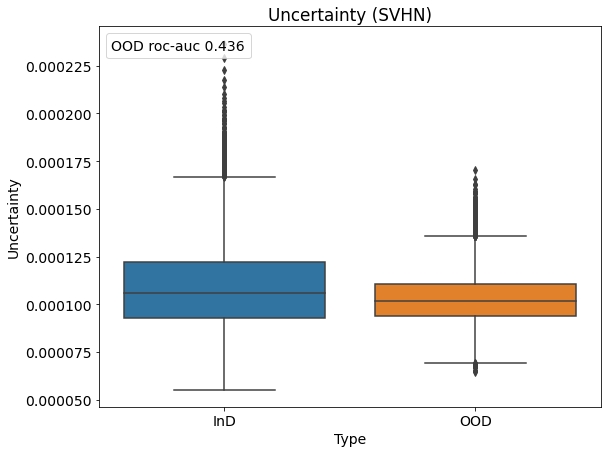

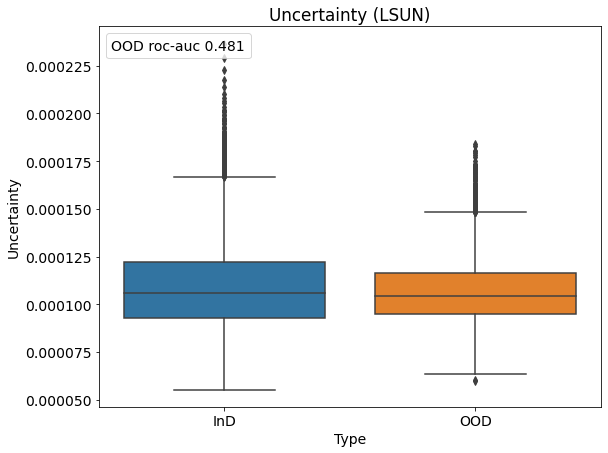

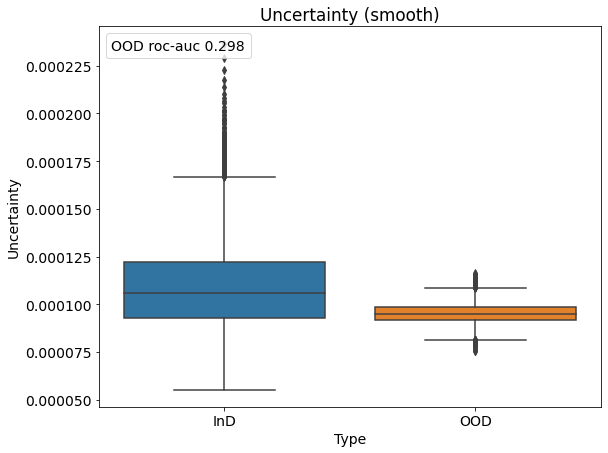

In [15]:
from metrics import uncertainty_plot

for name in tqdm(["SVHN", "LSUN", "smooth"]):
    uncertainty_plot(
        ues_all["cifar100"],
        ues_all[name.lower()],
        directory=join(DATA_DIR, "cifar100"),
        file_name=f"cifar100_ood_{name.lower()}",
        title=f"Uncertainty ({name})",
    )